## Time series project: anomaly detection

In [1]:
pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 110.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 96.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 25.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 134.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 158.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 131.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from pmdarima.arima import auto_arima

In [3]:
# Read data

df_raw_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv')
df_raw_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv')


test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv')
test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv')

In [4]:
df_raw_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [5]:
df_raw_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [6]:
df_raw_a

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08
...,...,...
415,2017-01-28 01:37:00,2.41
416,2017-01-28 01:38:00,2.16
417,2017-01-28 01:39:00,1.93
418,2017-01-28 01:40:00,2.14


In [21]:
# Change variable type

df_interim_a = df_raw_a.copy()
df_interim_b = df_raw_b.copy()

df_interim_a['datetime'] = pd.to_datetime(df_interim_a['datetime'])
df_interim_b['datetime'] = pd.to_datetime(df_interim_b['datetime'])

In [22]:
# Set time as index because we are working with time series

df_interim_a = df_interim_a.set_index(df_interim_a['datetime'])
df_interim_b = df_interim_b.set_index(df_interim_b['datetime'])

In [23]:
df_interim_a

,datetime,cpu
datetime,,
2017-01-27 18:42:00,2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,2017-01-27 18:46:00,1.08
...,...,...
2017-01-28 01:37:00,2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,2017-01-28 01:39:00,1.93


In [24]:
# Drop variables

df_interim_a = df_interim_a.drop('datetime', axis=1)
df_interim_b = df_interim_b.drop('datetime', axis=1)

In [25]:
df_interim_a

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08
...,...
2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,1.93


In [26]:
df_a = df_interim_a.copy()
df_b = df_interim_b.copy()

In [27]:
df_a.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [28]:
df_b.describe()

,cpu
count,600.000000
mean,1.282733
std,0.484951
min,0.570000
25%,0.840000
50%,1.240000
75%,1.610000
max,2.550000


<AxesSubplot:title={'center':'CPU Usage'}, xlabel='datetime'>

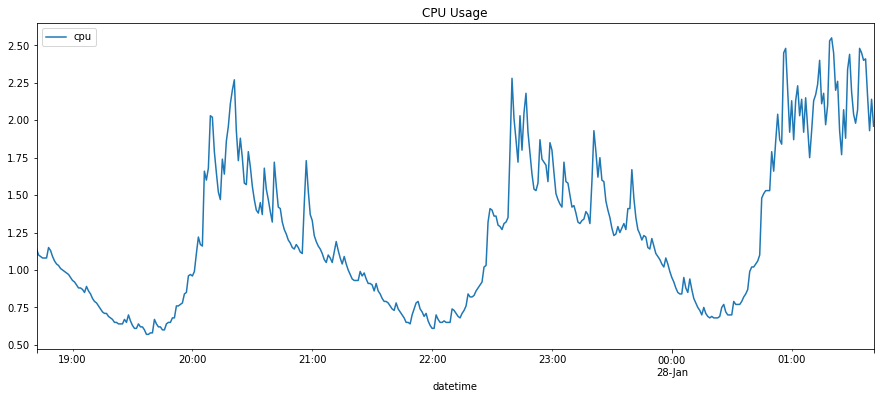

In [29]:
df_a.plot(title="CPU Usage", figsize=(15,6))

<AxesSubplot:title={'center':'CPU Usage'}, xlabel='datetime'>

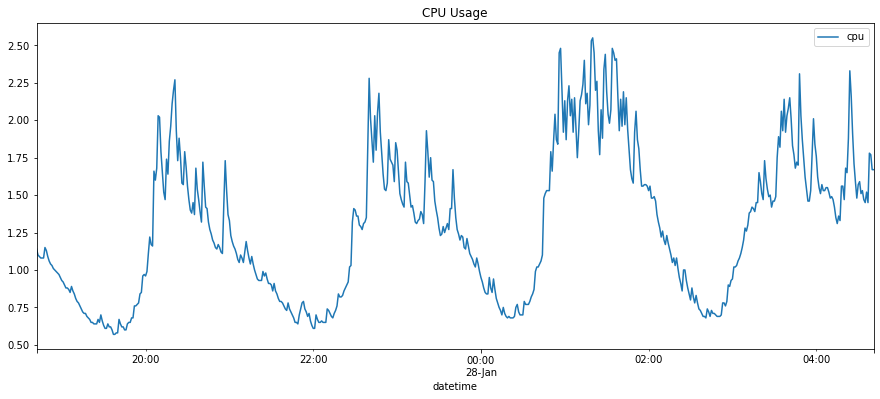

In [30]:
df_b.plot(title="CPU Usage", figsize=(15,6))

In [32]:
res = seasonal_decompose(df_a['cpu'].values, period=60) 

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

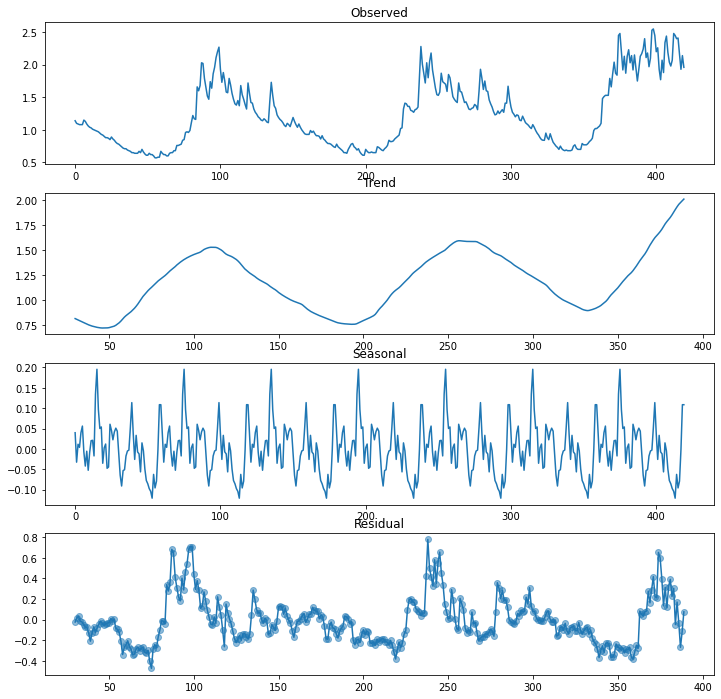

In [33]:
fig,ax = plt.subplots(4, figsize=(12,12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

In [39]:
stepwise_model = auto_arima(df_a, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=3,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-556.921, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-553.455, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-552.038, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-552.242, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-555.351, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-558.309, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-557.157, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-556.353, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-559.450, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-558.667, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-552.342, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-557.469, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-556.921, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-557.671, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [40]:
# Train the model

stepwise_model.fit(df_a)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

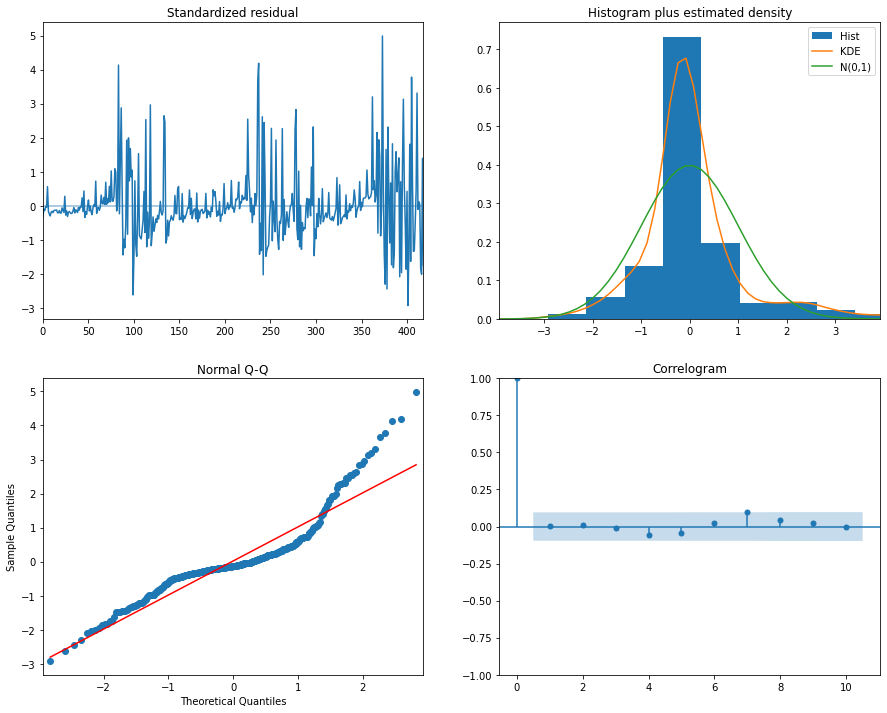

In [41]:
stepwise_model.fit(df_a).plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Predict values in the test set

forecast_a = stepwise_model.predict(n_periods=54)